# mTSP with A* and occupancy grid

In [18]:
import numpy as np
import math
import matplotlib.pyplot as plt
from PIL import Image
import heapq
import random
from itertools import cycle

# Load the PNG image and convert to an occupancy grid
image_path = "obstacleMap2.png"
image = Image.open(image_path).convert('L')  # Convert to grayscale
image_data = np.array(image)
threshold = 180
occupancy_grid = (image_data > threshold).astype(int)

numAgents = 2
numCities = 4

# Start coords based on map png used
# obstacleMap: (45,45), obstacleMap2: (30,30), obstacleMap3: (55,55), obstacleMap4: (50,50)
startPose = np.ones((numAgents, 2)) * 30 # start at same location

vels = np.ones(numAgents)

free_spaces = np.column_stack(np.where(occupancy_grid == 1))
chosen_indices = np.random.choice(free_spaces.shape[0], numCities, replace=False)
cityCoordinates = free_spaces[chosen_indices]

# Uncomment below if want to set custom cityCoords (must match numCities)
# cityCoordinates = np.array([[80,20],[10,80],[200,100],[150,250]])

numGenerations = 30
populationSize = 30
mutationRate = 0.01

plotting = True

# A* algorithm:
class Node:
    def __init__(self, position, parent=None, g=float('inf'), h=float('inf')):
        self.position = position
        self.parent = parent
        self.g = g
        self.h = h
        self.f = g + h

    def __lt__(self, other):
        return self.f < other.f

def heuristic(position, goal):
    # return math.sqrt((position[0] - goal[0])**2 + (position[1] - goal[1])**2)
    return abs(position[0] - goal[0]) + abs(position[1] - goal[1])

def a_star(occupancy_grid, start, goal):
    open_list = []
    closed_set = set()

    start_node = Node(start, None, 0, heuristic(start, goal))
    heapq.heappush(open_list, start_node)

    while open_list:
        current_node = heapq.heappop(open_list)

        if tuple(current_node.position) == tuple(goal):
            path = []
            while current_node:
                path.append(current_node.position)
                current_node = current_node.parent
            return path[::-1]

        closed_set.add(tuple(current_node.position))

        for dx in [-1, 0, 1]:
            for dy in [-1, 0, 1]:
                if dx == 0 and dy == 0:
                    continue
                neighbor_position = (int(current_node.position[0] + dx), int(current_node.position[1] + dy))

                if (0 <= neighbor_position[0] < occupancy_grid.shape[0] and
                    0 <= neighbor_position[1] < occupancy_grid.shape[1] and
                    occupancy_grid[neighbor_position[0], neighbor_position[1]] == 1 and
                    neighbor_position not in closed_set):

                    movement_cost = 1.414 if dx != 0 and dy != 0 else 1
                    new_g = current_node.g + movement_cost

                    # Check for the neighbor in open list
                    in_open_list = [node for node in open_list if node.position == neighbor_position]

                    if in_open_list:
                        if new_g < in_open_list[0].g:
                            open_list.remove(in_open_list[0])
                            in_open_list[0].g = new_g
                            in_open_list[0].f = new_g + in_open_list[0].h
                            in_open_list[0].parent = current_node
                            heapq.heappush(open_list, in_open_list[0])
                    else:
                        neighbor_node = Node(neighbor_position, current_node, new_g, heuristic(neighbor_position, goal))
                        heapq.heappush(open_list, neighbor_node)

    return None  # Path not found


# Genetic algorithm:
path_cache = {}

def totalDistance(path, coordinates, initPose, vels):
    totalDist = np.zeros(path.shape[1])
    for k in range(path.shape[1]):
        pathInds = path[:, k][path[:, k] >= 0]
        numCities = len(pathInds)
        city2 = initPose[k]
        for i in range(numCities):
            if i == 0:
                city1 = initPose[k]
            else:
                city1 = coordinates[pathInds[i - 1] - 1]
            city2 = coordinates[pathInds[i] - 1]

            # Use cached results if available
            path_key = (tuple(city1), tuple(city2))
            if path_key in path_cache:
                dist = path_cache[path_key]
            else:
                a_star_path = a_star(occupancy_grid, tuple(map(int, city1)), tuple(map(int, city2)))
                if a_star_path is None:
                    return float('inf')
                dist = len(a_star_path) / vels[k]
                path_cache[path_key] = dist

            totalDist[k] += dist
        
        a_star_path = a_star(occupancy_grid, city2, tuple(map(int, initPose[k])))
        if a_star_path is None:
            return float('inf')
        dist = len(a_star_path) / vels[k]
        totalDist[k] += dist
    return np.max(totalDist)

def swapMutation(path):
    mutatedPath = np.copy(path)
    for k in range(path.shape[1]):
        numCities = len(path[path[:, k] > 0])
        if numCities > 2:
            indices = random.sample(range(numCities), 2)
            mutatedPath[indices, k] = path[indices[::-1], k]
    return mutatedPath

def orderCrossover(parent1, parent2):
    numAgents = parent1.shape[1]
    numCities = parent1.shape[0]
    child1 = np.copy(parent1)
    child2 = np.copy(parent2)

    for k in range(numAgents):
        crossoverPoint1 = random.randint(1, numCities - 1)
        crossoverPoint2 = random.randint(crossoverPoint1 + 1, numCities)

        child1[crossoverPoint1:crossoverPoint2, k] = parent2[crossoverPoint1:crossoverPoint2, k]
        child2[crossoverPoint1:crossoverPoint2, k] = parent1[crossoverPoint1:crossoverPoint2, k]

    # Remove duplicates
    for agent in range(numAgents):
        for c in range(numCities):
            whichIdx1 = np.where(child1[:, agent] == c)[0]
            whichIdx2 = np.where(child2[:, agent] == c)[0]

            if len(whichIdx1) > 1:
                emptyIdx = random.choice(whichIdx1)
                child1[emptyIdx, agent] = -1

            if len(whichIdx2) > 1:
                emptyIdx = random.choice(whichIdx2)
                child2[emptyIdx, agent] = -1

    # Add missing cities
    for agent in range(numAgents):
        for c in range(numCities):
            if np.sum(child1 == c) == 0:
                emptySlots = np.where(child1[:, agent] == -1)[0]
                fillIdx = random.choice(emptySlots)
                child1[fillIdx, agent] = c

            if np.sum(child2 == c) == 0:
                emptySlots = np.where(child2[:, agent] == -1)[0]
                fillIdx = random.choice(emptySlots)
                child2[fillIdx, agent] = c

    return child1, child2

def generateUniquePaths(numCities, numAgents):
    paths = np.zeros((numCities, numAgents), dtype=int) - 1
    remainingCities = np.arange(0, numCities)

    agent_cycle = cycle(range(numAgents))
    
    for _ in range(numCities):
        randomChoice = random.choice(range(len(remainingCities)))
        agent = next(agent_cycle)
        
        # Find the next available slot for the agent
        available_slot = np.where(paths[:, agent] == -1)[0][0]

        paths[available_slot, agent] = remainingCities[randomChoice]
        remainingCities = np.delete(remainingCities, randomChoice)

    return paths

# Initialize the population
population = [generateUniquePaths(numCities, numAgents) for _ in range(populationSize)]

# Define the fitness function
def fitnessFunction(x):
    return totalDistance(x, cityCoordinates, startPose, vels)

# Run the genetic algorithm
for generation in range(numGenerations):
    # Evaluate fitness of the population
    fitness = np.array([fitnessFunction(p) for p in population])

    # Perform selection (tournament selection)
    selectedIndices = np.zeros(populationSize, dtype=int)
    for i in range(populationSize):
        tournamentIndices = random.sample(range(populationSize), 2)
        winnerIndex = tournamentIndices[np.argmin(fitness[tournamentIndices])]
        selectedIndices[i] = winnerIndex

    # Initialize offspring with zeros
    offspring = [np.zeros((numCities, numAgents), dtype=int) for _ in range(populationSize)]

    # Perform crossover (order crossover)
    for i in range(0, populationSize, 2):
        parent1 = population[selectedIndices[i]]
        parent2 = population[selectedIndices[i + 1]]
        child1, child2 = orderCrossover(parent1, parent2)
        offspring[i] = child1
        offspring[i + 1] = child2

    # Perform mutation (swap mutation)
    for i in range(populationSize):
        if random.random() < mutationRate:
            offspring[i] = swapMutation(offspring[i])

    # Replace the population with the offspring
    population = offspring

# Find the best solution for each agent
bestPaths = []
for agent in range(numAgents):
    bestIndex = 0
    bestFitness = fitnessFunction(population[0])
    for i in range(0, populationSize):
        currentFitness = fitnessFunction(population[i])
        if currentFitness < bestFitness:
            bestIndex = i
            bestFitness = currentFitness
    bestPaths.append(population[bestIndex][:, agent][population[bestIndex][:, agent] > -1])
    
# Print the best city-paths for each agent
for agent in range(numAgents):
    print(f'Agent {agent + 1} Path:', bestPaths[agent])

Agent 1 Path: [1 2 0]
Agent 2 Path: [3]


## View solution on map

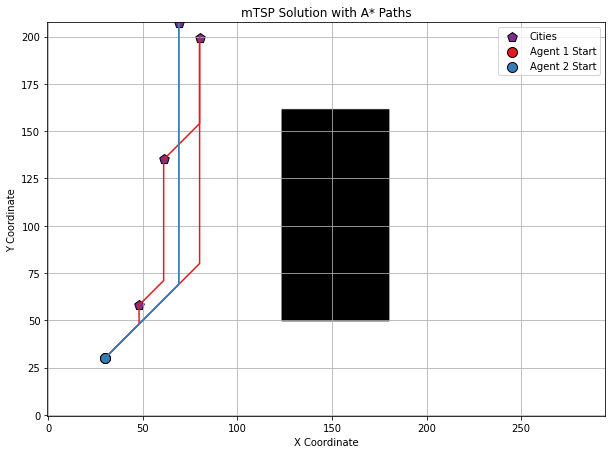

In [19]:
def plot_results(occupancy_grid, startPose, cityCoordinates, bestPaths, agents):
    plt.figure(figsize=(10, 10))
    
    # Display the occupancy grid as background
    plt.imshow(occupancy_grid, cmap='gray', origin='lower')
    
    # Plot the cities
    plt.scatter(cityCoordinates[:, 1], cityCoordinates[:, 0], s=100, c='#7E2F8E', edgecolors='k', marker='p', label='Cities')
    
    # Plot start positions of agents
    colors = ['#e41a1c', '#377eb8', '#4daf4a']
    for idx, pos in enumerate(startPose):
        plt.scatter(pos[1], pos[0], s=100, c=colors[idx], edgecolors='k', label=f'Agent {idx + 1} Start')
        
    # Plot paths of agents
    for idx, agent_path in enumerate(bestPaths):
        current_pos = tuple(map(int, startPose[idx]))
        for city in agent_path:
            next_pos = tuple(map(int, cityCoordinates[city-1]))
            path = a_star(occupancy_grid, current_pos, next_pos)
            if path:
                path = np.array(path)
                plt.plot(path[:, 1], path[:, 0], color=colors[idx], linestyle='-')
            current_pos = next_pos
            # add startPose to end of path
        current_pos = tuple(map(int, startPose[idx]))
        path = a_star(occupancy_grid, current_pos, next_pos)
        if path:
            path = np.array(path)
            plt.plot(path[:, 1], path[:, 0], color=colors[idx], linestyle='-')

    
    plt.legend(loc='upper right')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.title('mTSP Solution with A* Paths')
    plt.grid(True)
    plt.show()

# Call the plotting function
plot_results(occupancy_grid, startPose, cityCoordinates, bestPaths, numAgents)